# NuScenes Setup Guide

## 1. Nuscenes v1.0-mini Dataset Download

Use the following command to download the dataset:

```bash
curl --header 'Host: d36yt3mvayqw5m.cloudfront.net' --header 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7' --header 'Accept-Language: en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7' --header 'Referer: https://www.nuscenes.org/' 'https://d36yt3mvayqw5m.cloudfront.net/public/v1.0/v1.0-mini.tgz' -L -o 'v1.0-mini.tgz'
```

After downloading, unzip the file:

```bash
tar -xvzf v1.0-mini.tgz
```

---

## 2. Nuscenes Package Installation

Install the nuscenes-devkit package using pip:

```bash
pip install nuscenes-devkit
```

You can find the official repo here: [nuscenes-devkit](https://github.com/nutonomy/nuscenes-devkit)

---

## 3. Nuscenes Map Expansion (For Visualization)

Download the map expansion file:

```bash
curl --header 'Host: d36yt3mvayqw5m.cloudfront.net' --header 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7' --header 'Accept-Language: en-US,en;q=0.9,zh-CN;q=0.8,zh;q=0.7' --header 'Referer: https://www.nuscenes.org/' 'https://d36yt3mvayqw5m.cloudfront.net/public/v1.0/nuScenes-map-expansion-v1.3.zip' -L -o 'nuScenes-map-expansion-v1.3.zip'
```

Unzip the file:

```bash
unzip nuScenes-map-expansion-v1.3.zip
```

Then copy the `/expansion` folder and paste it to your data directory in step 1:

You will have `YOUR_DATA_ROOT/nuscenes/maps/expansion/...`

---


\* If you find the dataset is incomplete, please check official download page: [link](https://www.nuscenes.org/nuscenes#download)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
from collections import defaultdict, OrderedDict



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/aleenatron/miniconda3/envs/frames_av/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/aleenatron/miniconda3/envs/frames_av/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/aleenatron/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/aleenatron/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [2]:
import os

# Initialize nuScenes dataset
dataroot = os.path.expanduser('~/Desktop/Nuscenes/nuscenes')
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

# Select a scene
scene = nusc.scene[2]
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)
ego_vehicle_start_time = sample['timestamp']

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.167 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [3]:
scene['description']

'Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller'

In [4]:
# Get the correct map for the scene
log = nusc.get("log", scene["log_token"])
location = log["location"]
nusc_map = NuScenesMap(dataroot='/Users/liliu/Desktop/Nuscenes/nuscenes', map_name=location)

# Store ego trajectory and object trajectories
ego_trajectory = []
ego_orientations = []
timestamps = []

object_trajectories = defaultdict(list)
object_orientations = defaultdict(list)
object_labels = {}
object_categories = {}  # Store category for each instance

# Function to convert quaternion to 2D yaw angle
def quaternion_to_yaw(quaternion):
    q = Quaternion(quaternion)
    yaw = np.arctan2(2.0 * (q.w * q.z + q.x * q.y), 1.0 - 2.0 * (q.y * q.y + q.z * q.z))
    return yaw

# Track object instances separately
object_name_counter = defaultdict(int)

# Loop through all samples in the scene
sample_token = first_sample_token
while sample_token:
    sample = nusc.get('sample', sample_token)

    # Get timestamp (normalize between 0 and 1 for transparency)
    timestamps.append(sample['timestamp'])

    # Get ego_pose information
    sample_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])  # Using LiDAR for reference
    ego_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])
    ego_position = tuple(ego_pose['translation'][:2])  # X, Y position
    ego_yaw = quaternion_to_yaw(ego_pose['rotation'])  # Get orientation (yaw)

    ego_trajectory.append(ego_position)
    ego_orientations.append(ego_yaw)

    # Track all objects in the scene
    for ann_token in sample['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        instance_token = ann_data['instance_token']
        object_position = tuple(ann_data['translation'][:2])  # Convert to tuple for uniqueness
        object_yaw = quaternion_to_yaw(ann_data['rotation'])  # Get orientation (yaw)

        # Get object category name
        category_name = ann_data['category_name']
        object_categories[instance_token] = category_name  # Store category

        # Differentiate identical objects with numbering (_1, _2, ...)
        if instance_token not in object_labels:
            object_name_counter[category_name] += 1
            unique_name = f"{category_name}_{object_name_counter[category_name]}"  # Append instance number
            object_labels[instance_token] = unique_name

        # Store object trajectory and orientation
        object_trajectories[instance_token].append(object_position)
        object_orientations[instance_token].append(object_yaw)

    # Move to the next sample
    sample_token = sample['next']

# Normalize timestamps for transparency (0 = oldest, 1 = newest)
timestamps = np.array(timestamps)
timestamps = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())  # Normalize between 0 and 1

# Convert ego trajectory to NumPy arrays for plotting
ego_trajectory = np.array(ego_trajectory)
ego_orientations = np.array(ego_orientations)

## Get the most obvious moving objects (with their unique locations)

In [5]:

# **Count unique locations per object (at ranking stage)**
unique_location_counts = {}
filtered_trajectories = {}
filtered_orientations = {}

for instance_token, trajectory in object_trajectories.items():
    unique_locs = OrderedDict()  # Ensure order and store first occurrence of each location
    for i, loc in enumerate(trajectory):
        if loc not in unique_locs:
            unique_locs[loc] = object_orientations[instance_token][i]  # Store first orientation for each unique loc
    
    unique_location_counts[instance_token] = len(unique_locs)  # Count unique locations
    filtered_trajectories[instance_token] = list(unique_locs.keys())  # Store unique locations
    filtered_orientations[instance_token] = list(unique_locs.values())  # Store linked orientations

# **Sort and filter the top 10 longest unique-location trajectories (including ties)**
sorted_lengths = sorted(set(unique_location_counts.values()), reverse=True)  # Get unique lengths, sorted descending

# Keep all objects with trajectory length in the top 10 unique values
if len(sorted_lengths) > 10:
    threshold_length = sorted_lengths[9]  # Get the 10th longest unique length
    selected_instances = {k for k, v in unique_location_counts.items() if v >= threshold_length}
else:
    selected_instances = set(unique_location_counts.keys())  # If fewer than 10 unique lengths, plot all

In [6]:
selected_instances

{'18cdcf0d2340409b95140ea38a70fd2e',
 '19804c352c0a4767b61b8d0709d1db99',
 '21d4060224a946e5b66fd00749282e82',
 '2397a588f42e4195bf7fb0148aa7a3d6',
 '2e19253f3bac458191cf64ff2b22ba2b',
 '340ccb3c0dcb492eaa032f0e4e3017bb',
 '3993afe444aa4497b1fec37c89fcc369',
 '4f41f55039c34783b0f63a3ebc196434',
 '6ae762f1bc254d00bfb5ae9d66ffe376',
 '6b9c9912fecb4847b93e81eb10da83a2',
 '7c6e078abfa74db5a5439711383a8f5b',
 '888521a8b57f46258e81a89bf062278b',
 '94e0b9b077774f18a74f53c5305a368d',
 '9e94bea2db384cf1ba7264e02920b1d8',
 'afd097377c71479ea8349eeae83b8143',
 'b2a522c239af44e0927a51c941bd256e',
 'b4db00c7834047799104363c10eca351',
 'b61b72a5b5ad482e9bc94c203f75b8d4',
 'bdb82f4d50ce47e6b3925471c049355e',
 'd9a4df9e92804a44a039eb21e0dc1349',
 'e2afd7eaa5c04cff9e59ca025e14249c',
 'e8ee78065abc41ac9dcae839a29eac0b',
 'ecf7d2d3b0984505a33fc612ac350e6b',
 'f442a98a9a354484aef5240bb21e7691',
 'f53b4aa3d74e473c90afb956e618e3ce',
 'fb0b1fa4a33a43ea9cc802ba14a40586'}

## Get the instance Frames with the Top-ridar's coordinate system (coordinate defined as: X-right, Y-forward)

In [7]:
instance_id = "6ae762f1bc254d00bfb5ae9d66ffe376"
print_debug = False

In [8]:
from collections import defaultdict, OrderedDict
import numpy as np
from pyquaternion import Quaternion
import os
from nuscenes.nuscenes import NuScenes


# Precompute ego vehicle positions
def compute_scene_ego_positions(nusc, scene_index):
    scene_ego_positions = {}
    scene = nusc.scene[scene_index]
    first_sample_token = scene['first_sample_token']
    first_sample = nusc.get('sample', first_sample_token)
    ego_vehicle_raw_start_time = first_sample['timestamp'] / 1e6

    sample_token = first_sample_token
    while sample_token:
        sample = nusc.get('sample', sample_token)
        timestamp = sample['timestamp'] / 1e6
        sample_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        ego_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])
        scene_ego_positions[timestamp] = tuple(ego_pose['translation'][:2])
        sample_token = sample['next']

    return scene_ego_positions, ego_vehicle_raw_start_time

class InstanceFrame:
    """ Class to store and process instance frame information from nuScenes dataset. """
    
    def __init__(self, nusc, instance_token, scene_index, scene_ego_positions, ego_vehicle_raw_start_time):
        """
        Initializes an InstanceFrame object and extracts relevant data.

        Args:
            nusc: NuScenes database instance.
            instance_token: The token of the instance to extract.
            scene_index: The index of the scene in nuScenes dataset.
            scene_ego_positions: Precomputed ego vehicle positions for this scene.
            ego_vehicle_raw_start_time: The raw start timestamp of the ego vehicle (in seconds).
        """
        self.nusc = nusc
        self.instance_token = instance_token
        self.scene_index = scene_index
        self.scene_ego_positions = scene_ego_positions
        self.ego_vehicle_raw_start_time = ego_vehicle_raw_start_time

        # Core attributes
        self.category_name = None
        self.instance_name = None
        self.start_time = None
        self.end_time = None
        self.duration = None
        self.raw_start_time = None
        self.raw_end_time = None
        self.locations = []
        self.orientations = []
        self.sample_tokens = []
        self.scene_token = None

        # Extract information
        self._extract_instance_data()
        self._normalize_times()

    def _extract_instance_data(self):
        """ Extract structured Frame representation for the instance in nuScenes. """

        instance = self.nusc.get('instance', self.instance_token)
        first_ann_token = instance['first_annotation_token']
        
        ann = self.nusc.get('sample_annotation', first_ann_token)
        self.category_name = ann['category_name']

        while ann:
            sample = self.nusc.get('sample', ann['sample_token'])
            timestamp = sample['timestamp'] / 1e6  # Convert to seconds

            if self.start_time is None:
                self.start_time = timestamp
                self.raw_start_time = timestamp
                self.scene_token = sample["scene_token"]

            self.end_time = timestamp
            self.raw_end_time = timestamp

            # Transform annotation from global frame to LiDAR frame
            lidar_translation, lidar_rotation = self._get_lidar_pose(sample['data']['LIDAR_TOP'])
            obj_translation = np.array(ann["translation"])
            obj_rotation = Quaternion(ann["rotation"])

            transformed_translation, transformed_yaw = self._transform_global_to_lidar(
                obj_translation, obj_rotation, lidar_translation, lidar_rotation
            )

            self.locations.append(transformed_translation[:2])  # X, Y in LiDAR frame
            self.orientations.append(transformed_yaw)  # Yaw in LiDAR frame

            self.sample_tokens.append(ann["sample_token"])

            if ann["next"]:
                ann = self.nusc.get("sample_annotation", ann["next"])
            else:
                break

        self.duration = self.end_time - self.start_time

    def _normalize_times(self):
        """ Normalize start and end times relative to the ego vehicle's first timestamp in the scene. """
        self.start_time -= self.ego_vehicle_raw_start_time
        self.end_time -= self.ego_vehicle_raw_start_time

    def _get_lidar_pose(self, lidar_token):
        """ Retrieve the LiDAR position and rotation from ego pose. """
        lidar_data = self.nusc.get('sample_data', lidar_token)
        ego_pose = self.nusc.get('ego_pose', lidar_data['ego_pose_token'])
        return np.array(ego_pose['translation']), Quaternion(ego_pose['rotation'])

    def _transform_global_to_lidar(self, obj_translation, obj_rotation, lidar_translation, lidar_rotation):
        """
        Transform object position and orientation from global frame to the LiDAR frame.
        """
    

    
        # Step 1: Translate to LiDAR's origin
        relative_translation = obj_translation - lidar_translation

    
        # Step 2: Rotate using inverse of LiDAR rotation
        transformed_translation = lidar_rotation.inverse.rotate(relative_translation)
        
        # **Fix the Axis Swapping Issue**
        transformed_translation = np.array([-transformed_translation[1], transformed_translation[0], transformed_translation[2]])
        

        # Step 3: Convert rotation to LiDAR's frame

        transformed_rotation = lidar_rotation.inverse * obj_rotation
        transformed_yaw = np.arctan2(
            2.0 * (transformed_rotation.w * transformed_rotation.z + transformed_rotation.x * transformed_rotation.y),
            1.0 - 2.0 * (transformed_rotation.y**2 + transformed_rotation.z**2)
        )
    

        # Choose whether debug with print
        if print_debug:
            print(f" LiDAR Position: {obj_rotation}")           
            print(f" Global Position: {obj_translation}")
            print(f" LiDAR Position: {lidar_translation}")
            print(f" Relative Position (before rotation): {relative_translation}")
            print(f"✅ Fixed Transformed Position (LiDAR Frame): {transformed_translation}")
            print(f" Original Rotation (Quaternion): {obj_rotation}")
            print(f"✅ Transformed Yaw (LiDAR Frame): {np.degrees(transformed_yaw)} degrees")
    
        return transformed_translation, transformed_yaw


    def _classify_orientation(self, yaw_rad):
        """ Classify the relative orientation in LiDAR frame. """
        yaw_deg = np.degrees(yaw_rad) % 360
        if yaw_deg > 180:
            yaw_deg -= 360  # Normalize to [-180, 180]

        if abs(yaw_deg) < 45:
            return "facing same direction"
        elif abs(yaw_deg - 180) < 45 or abs(yaw_deg + 180) < 45:
            return "facing opposite direction"
        elif 45 <= yaw_deg <= 135:
            return "facing leftward (perpendicular)"
        elif -135 <= yaw_deg <= -45:
            return "facing rightward (perpendicular)"
        else:
            return "heading unclear"



    def describe_movement(self):
        """
        A detailed scenario-based & dominant-direction movement description
        in LiDAR frame (x=right, y=up), considering the **entire trajectory**.
    
        Key features:
        - Describes movement trends over time.
        - Separates Left/Right and Forward/Backward positioning (no center state).
        - Tracks relative positioning with respect to the ego vehicle.
        - Detects crossing events (left↔right, behind↔ahead).
        - Computes movement dominance dynamically.
        - Reports mean and minimum distance to the ego vehicle.
    
        The 'one region' logic: explicitly says "always left/right" or "always behind/ahead"
        if applicable.



        TODO: 
              1. We take the relative distances as the trajectory distance (which might not be the same as the actual path length, according to the ego vehicle).
        """
    
        if len(self.locations) < 2:
            return "Not enough data to describe movement."
    
        distances_to_ego = [np.linalg.norm(loc) for loc in self.locations]
        mean_distance = np.mean(distances_to_ego)
        min_distance = np.min(distances_to_ego)

        movement_segments = []
        heading_segments = []
        segment_changes_lr = []
        segment_changes_fb = []
        relative_lr = []
        relative_fb = []
        total_distance = 0

        prev_x, prev_y = self.locations[0]

        for i in range(1, len(self.locations)):
            cur_x, cur_y = self.locations[i]
            dx, dy = cur_x - prev_x, cur_y - prev_y
            distance = np.hypot(dx, dy)
            total_distance += distance

            # --- Movement direction ---
            if distance < 0.5:
                move_desc = "had minor movement"
            else:
                abs_dx, abs_dy = abs(dx), abs(dy)
                ratio = abs_dx / abs_dy if abs_dy > 1e-6 else float('inf')
                if ratio > 1.5:
                    move_desc = "moved dominantly right" if dx > 0 else "moved dominantly left"
                elif ratio < 0.66:
                    move_desc = "moved dominantly forward" if dy > 0 else "moved dominantly backward"
                else:
                    move_desc = "moved diagonally"
            movement_segments.append(move_desc)

            # --- Orientation status ---
            heading_segments.append(self._classify_orientation(self.orientations[i]))

            # --- Relative lateral / longitudinal position ---
            cur_lr = "left" if cur_x < 0 else "right"
            cur_fb = "behind" if cur_y < 0 else "ahead"

            if i > 1:
                prev_lr, prev_fb = relative_lr[-1], relative_fb[-1]
                if prev_lr != cur_lr:
                    segment_changes_lr.append(f"crossed from {prev_lr} to {cur_lr}")
                if prev_fb != cur_fb:
                    segment_changes_fb.append(f"crossed from {prev_fb} to {cur_fb}")

            relative_lr.append(cur_lr)
            relative_fb.append(cur_fb)

            prev_x, prev_y = cur_x, cur_y

        movement_trend = ", then ".join(dict.fromkeys(movement_segments))
        heading_trend = ", then ".join(dict.fromkeys(heading_segments))

        # Position summaries
        lr_summary = (
            f"always {relative_lr[0]}" if len(set(relative_lr)) == 1 else
            ", ".join(dict.fromkeys(segment_changes_lr)) if segment_changes_lr else
            "exhibited partial left/right shifts"
        )
        fb_summary = (
            f"always {relative_fb[0]}" if len(set(relative_fb)) == 1 else
            ", ".join(dict.fromkeys(segment_changes_fb)) if segment_changes_fb else
            "exhibited partial forward/back shifts"
        )

        return (
            f"A {self.category_name} {movement_trend}. "
            f"Relative to the ego vehicle, it was {lr_summary} laterally "
            f"and {fb_summary} longitudinally. "
            f"It covered a total distance of approximately {total_distance:.2f}m over {self.duration:.2f}s. "
            f"Mean distance: {mean_distance:.2f}m, closest approach: {min_distance:.2f}m. "
            f"Its orientation over time was: {heading_trend}."
        )





    def to_dict(self):
        """ Converts the instance frame object to a dictionary for easy usage. """
        return {
            "instance_token": self.instance_token,
            "category_name": self.category_name,
            "instance_name": self.instance_name,
            "raw_start_time": self.raw_start_time,
            "raw_end_time": self.raw_end_time,
            "ego_vehicle_raw_start_time": self.ego_vehicle_raw_start_time,
            "start_time": self.start_time,
            "end_time": self.end_time,
            "duration": self.duration,
            "locations": self.locations,
            "orientations": self.orientations,
            "sample_tokens": self.sample_tokens,
            "scene_token": self.scene_token,
            "description": self.describe_movement()
        }

# Example usage:
# scene_ego_positions, ego_vehicle_raw_start_time = compute_scene_ego_positions(nusc, 2)
# instance_frame = InstanceFrame(nusc, instance_id, 2, scene_ego_positions, ego_vehicle_raw_start_time)#888521a8b57f46258e81a89bf062278b
# print(instance_frame.to_dict())

## Get the description for all filtered instances

In [9]:
scene_ego_positions, ego_vehicle_raw_start_time = compute_scene_ego_positions(nusc, 2)
instance_descriptions = []
for instance_id in selected_instances:
    instance_frame = InstanceFrame(nusc, instance_id, 2, scene_ego_positions, ego_vehicle_raw_start_time)
    print('instance_id:', instance_id)
    print(instance_frame.describe_movement())
    print("\n")
    instance_descriptions.append(instance_frame.describe_movement())

instance_id: 888521a8b57f46258e81a89bf062278b
A vehicle.car moved dominantly backward, then had minor movement. Relative to the ego vehicle, it was always left laterally and always ahead longitudinally. It covered a total distance of approximately 104.32m over 19.90s. Mean distance: 76.52m, closest approach: 50.53m. Its orientation over time was: facing opposite direction.


instance_id: b61b72a5b5ad482e9bc94c203f75b8d4
A human.pedestrian.adult moved dominantly right. Relative to the ego vehicle, it was crossed from left to right laterally and always ahead longitudinally. It covered a total distance of approximately 24.36m over 19.90s. Mean distance: 12.38m, closest approach: 8.09m. Its orientation over time was: facing rightward (perpendicular).


instance_id: 21d4060224a946e5b66fd00749282e82
A human.pedestrian.adult moved dominantly right, then moved diagonally, then had minor movement. Relative to the ego vehicle, it was crossed from left to right laterally and always ahead longitud

## Try to get the overall description of a scene (concatenate all instances' descriptions)

In [10]:
overall_description = ''.join(instance_descriptions)

In [11]:
overall_description

'A vehicle.car moved dominantly backward, then had minor movement. Relative to the ego vehicle, it was always left laterally and always ahead longitudinally. It covered a total distance of approximately 104.32m over 19.90s. Mean distance: 76.52m, closest approach: 50.53m. Its orientation over time was: facing opposite direction.A human.pedestrian.adult moved dominantly right. Relative to the ego vehicle, it was crossed from left to right laterally and always ahead longitudinally. It covered a total distance of approximately 24.36m over 19.90s. Mean distance: 12.38m, closest approach: 8.09m. Its orientation over time was: facing rightward (perpendicular).A human.pedestrian.adult moved dominantly right, then moved diagonally, then had minor movement. Relative to the ego vehicle, it was crossed from left to right laterally and always ahead longitudinally. It covered a total distance of approximately 21.84m over 19.90s. Mean distance: 11.52m, closest approach: 9.38m. Its orientation over t

### You should set up OPENAI_API_KEY before calling the openai models

In [12]:
from openai import OpenAI
client = OpenAI()

response = client.responses.create(
    model="gpt-4o-mini",
    input=f"Write a one-sentence summary about the scene, identify specific important objects in autonomous driving scenarios:{overall_description}."
)

print(response.output_text)

In a complex autonomous driving scenario, multiple entities—including vehicles, pedestrians, and barriers—exhibited varied movements and interactions, with significant distances covered, close approaches, and distinct orientations, all of which are critical for the ego vehicle's navigation and safety assessments. Key objects include various vehicles (cars, buses, trucks), human pedestrians, movable barriers, and pushable objects that play pivotal roles in unpredictable traffic dynamics.


In [13]:
# Provide a template for the summary (use the first scene description as a reference, but please do not use the current scene description):

from openai import OpenAI
client = OpenAI()

response = client.responses.create(
    model="gpt-4o-mini",
    input=f"Write a one-sentence summary about the scene, identify specific important objects in autonomous driving scenarios:{overall_description}. You should output the summary like {nusc.scene[1]['description']}. "
)

print(response.output_text)

Many peds right, backward car ahead left, moving bus left, some barriers, wait for truck, minor car movements left.


In [14]:
# The ground truth for the scene description from the nuScenes dataset:
nusc.scene[2]['description']

'Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller'

## Validate the Frame description of an instance with its birds-eye-view visualization

Check an id "instance_id = '2e19253f3bac458191cf64ff2b22ba2b'". A bus turnning left (from birds-eye view)

In [15]:
instance_id = '2e19253f3bac458191cf64ff2b22ba2b'

In [16]:
instance_frame = InstanceFrame(nusc, instance_id, 2, scene_ego_positions, ego_vehicle_raw_start_time)
print('instance_id:', instance_id)
print(instance_frame.describe_movement())

instance_id: 2e19253f3bac458191cf64ff2b22ba2b
A vehicle.bus.rigid had minor movement, then moved dominantly right, then moved diagonally, then moved dominantly forward. Relative to the ego vehicle, it was always left laterally and always ahead longitudinally. It covered a total distance of approximately 134.36m over 19.40s. Mean distance: 63.99m, closest approach: 32.25m. Its orientation over time was: facing rightward (perpendicular), then facing same direction.


### Visualize the selected instance and put it on the map

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.181 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


/opt/anaconda3/envs/nuscenes/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/opt/anaconda3/envs/nuscenes/lib/python3.9/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


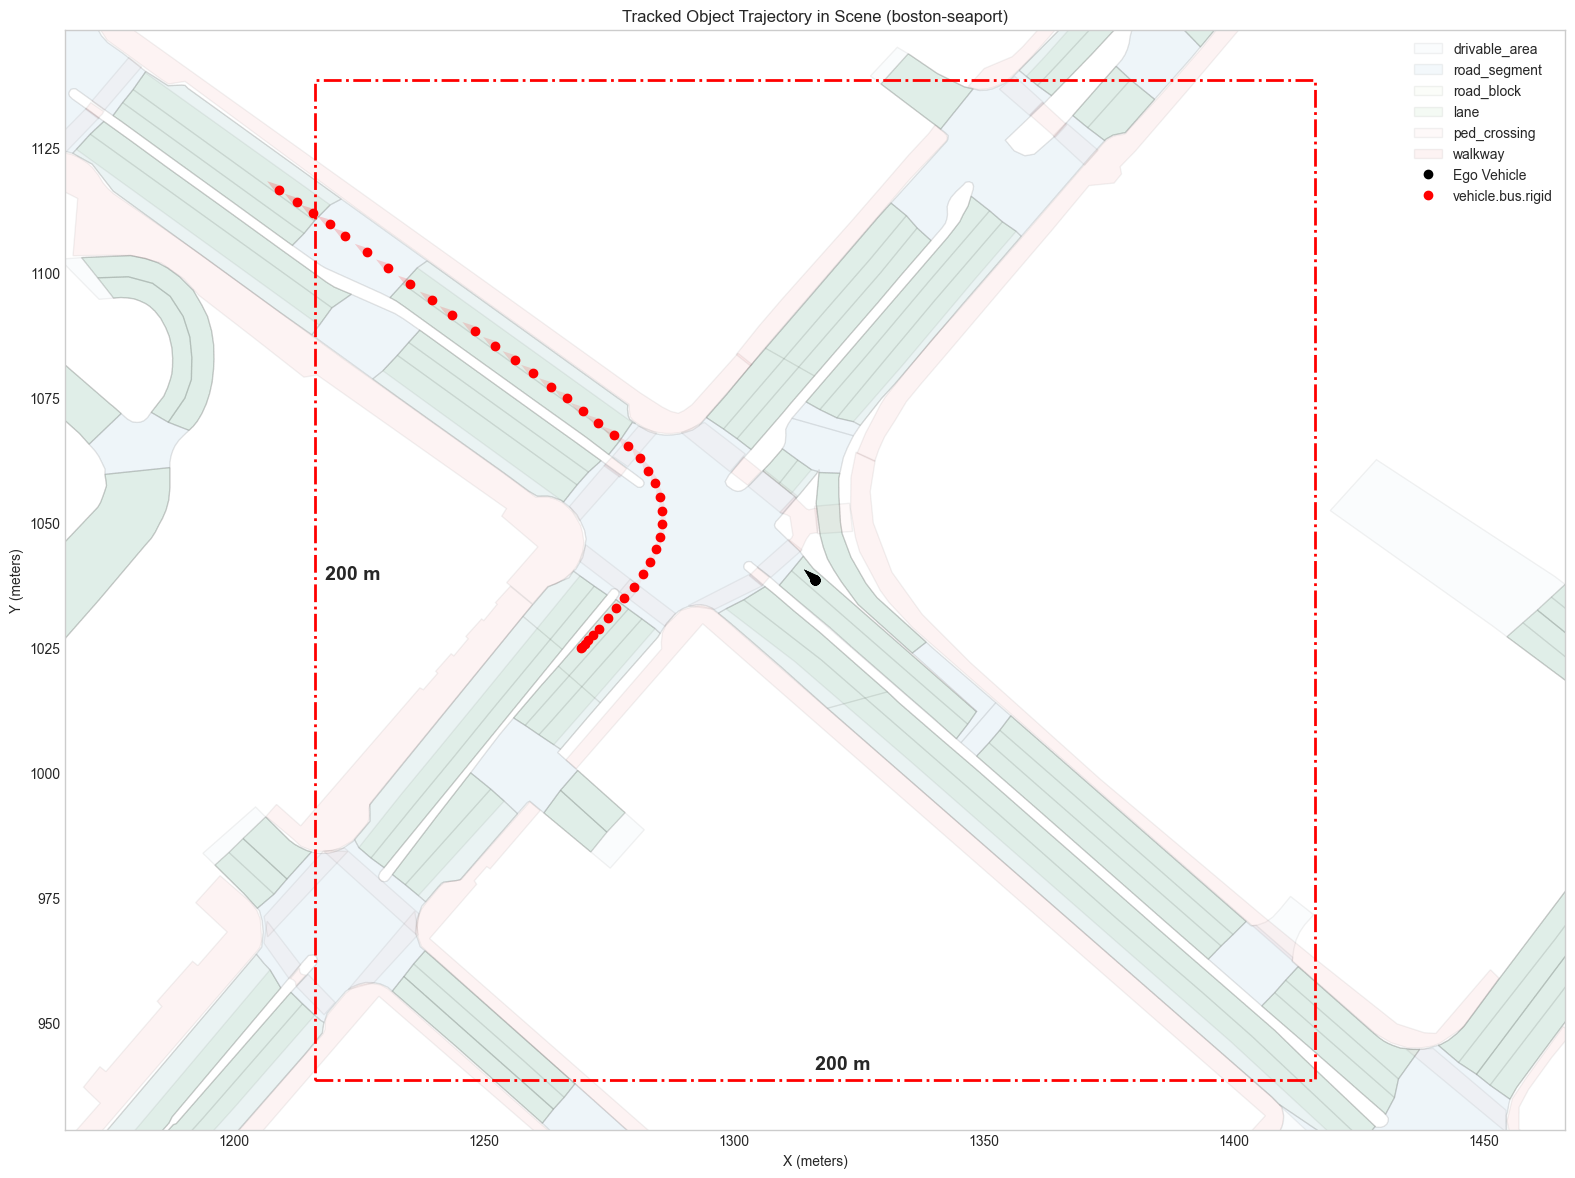

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import defaultdict, OrderedDict
from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

# Toggle to control arrow display (set to False to hide arrows)
show_arrows = True

# Step 1: Load nuScenes dataset
dataroot = "/Users/liliu/Desktop/Nuscenes/nuscenes"  # Adjust this path as needed
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

# Step 2: Define the scene and the instance you want to visualize
scene_index = 2  # Adjust this to your scene index
instance_token = instance_id  # Replace with the actual instance token

# Step 3: Load scene and map
scene = nusc.scene[scene_index]
first_sample_token = scene['first_sample_token']
log = nusc.get("log", scene["log_token"])
location = log["location"]
nusc_map = NuScenesMap(dataroot=dataroot, map_name=location)

# Step 4: Function to convert quaternion to yaw
def quaternion_to_yaw(quaternion):
    q = Quaternion(quaternion)
    return np.arctan2(2.0*(q.w*q.z + q.x*q.y), 1.0 - 2.0*(q.y*q.y + q.z*q.z))

# Step 5: Store trajectories
ego_trajectory = []
ego_orientations = []
timestamps = []
object_trajectory = []
object_orientations = []

# Step 6: Loop through all samples in the scene
sample_token = first_sample_token
while sample_token:
    sample = nusc.get('sample', sample_token)
    timestamps.append(sample['timestamp'])
    
    # Get ego vehicle pose using LIDAR_TOP
    sample_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    ego_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])
    ego_trajectory.append(tuple(ego_pose['translation'][:2]))  # X, Y position
    ego_orientations.append(quaternion_to_yaw(ego_pose['rotation']))
    
    # Process all objects in the scene; only consider the specified instance
    for ann_token in sample['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        if ann_data['instance_token'] == instance_token:
            object_trajectory.append(tuple(ann_data['translation'][:2]))
            object_orientations.append(quaternion_to_yaw(ann_data['rotation']))
    
    sample_token = sample['next']

# Step 7: Normalize timestamps
timestamps = np.array(timestamps)
timestamps = (timestamps - timestamps.min()) / (timestamps.max() - timestamps.min())

# Step 8: Convert lists to NumPy arrays
ego_trajectory = np.array(ego_trajectory)
ego_orientations = np.array(ego_orientations)
object_trajectory = np.array(object_trajectory)
object_orientations = np.array(object_orientations)

# Step 9: Determine map bounds
x_min, y_min = np.min(ego_trajectory, axis=0) - 100
x_max, y_max = np.max(ego_trajectory, axis=0) + 100
map_bounds = (x_min, y_min, x_max, y_max)

# Step 10: Define map layers
layer_names = ["drivable_area", "road_segment", "road_block", "lane", "ped_crossing", "walkway"]

# Step 11: Render the map patch with 50% transparency
fig, ax = nusc_map.render_map_patch(map_bounds, layer_names, alpha=0.05)
ax.set_aspect('equal')

# Step 12: Plot ego vehicle trajectory in black and add arrows (if enabled)
ax.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], 'o', color="black", label="Ego Vehicle")
if show_arrows:
    for i in range(len(ego_trajectory)):
        alpha = timestamps[i]
        dx = 3 * np.cos(ego_orientations[i])
        dy = 3 * np.sin(ego_orientations[i])
        ax.quiver(ego_trajectory[i, 0], ego_trajectory[i, 1], dx, dy,
                  angles='xy', scale_units='xy', scale=1, color=(0,0,0,0.2*alpha))

# Step 13: Plot object trajectory in red and add arrows (if enabled)
ax.plot(object_trajectory[:, 0], object_trajectory[:, 1], 'o', color="red", label=f"{instance_frame.category_name}")
if show_arrows:
    for i in range(len(object_trajectory)):
        alpha = timestamps[i]
        dx = 3 * np.cos(object_orientations[i])
        dy = 3 * np.sin(object_orientations[i])
        ax.quiver(object_trajectory[i, 0], object_trajectory[i, 1], dx, dy,
                  angles='xy', scale_units='xy', scale=1, color=(1,0,0,0.2*alpha))

# Step 14: Labels and legend
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title(f"Tracked Object Trajectory in Scene ({location})")
plt.legend()
plt.grid()
plt.show()